# **Library and Configuration**

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics import (
    confusion_matrix, 
    classification_report
)

import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import (
    Dataset, 
    DataLoader
)
from torchvision import (
    transforms,
    models
)
from torch.utils.data import (
    TensorDataset, 
    DataLoader, 
    WeightedRandomSampler
)

SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

root_input = Path("/kaggle/input/data-mining-action-2025")
root_output = Path("/kaggle/working")

train_dir = root_input/'train/train'
test_dir = root_input/'test/test'

def set_all_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)

set_all_seeds()
print('You are all set!')

You are all set!


# **Constructing Dataset**

# **Train and Test Inspection**

In [2]:
exts = ["*.jpg", "*.png", "*.jpeg"]

train_paths = []
test_paths  = []

for ext in exts:
    train_paths.extend(train_dir.glob(ext))
    test_paths.extend(test_dir.glob(ext))

print("Full train length :", len(train_paths))
print("Test length       :", len(test_paths))

Full train length : 4257
Test length       : 2057


In [3]:
def check_integrity(paths):
    bad_files = []
    good_files = []

    for p in tqdm(paths):
        try:
            with Image.open(p) as img:
                img.verify()
            good_files.append(p)
        except Exception:
            bad_files.append(p)

    return good_files, bad_files

train_good, train_bad = check_integrity(train_paths)
test_good,  test_bad  = check_integrity(test_paths)

print("Train corrupt:", len(train_bad))
print("Test corrupt :", len(test_bad))

100%|██████████| 2057/2057 [00:15<00:00, 130.95it/s]

Train corrupt: 0
Test corrupt : 0


In [4]:
def inspect_image(path):
    img = Image.open(path).convert("RGB")
    w, h = img.size
    arr = np.array(img)

    mean_intensity = arr.mean()
    std_intensity  = arr.std()

    gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    blur = cv2.Laplacian(gray, cv2.CV_64F).var()

    return {
        "width": w,
        "height": h,
        "aspect_ratio": w / h,
        "mean": mean_intensity,
        "std": std_intensity,
        "blur": blur,
    }

train_records = []
for p in tqdm(train_paths):
    try:
        stats = inspect_image(p)
        stats["filepath"] = p
        train_records.append(stats)
    except Exception as e:
        pass

train_inspect_df = pd.DataFrame(train_records)

test_records = []
for p in tqdm(test_paths):
    try:
        stats = inspect_image(p)
        stats["filepath"] = p
        test_records.append(stats)
    except Exception as e:
        pass

test_inspect_df = pd.DataFrame(test_records)

100%|██████████| 2057/2057 [00:16<00:00, 126.36it/s]


# Train and Test Exploration

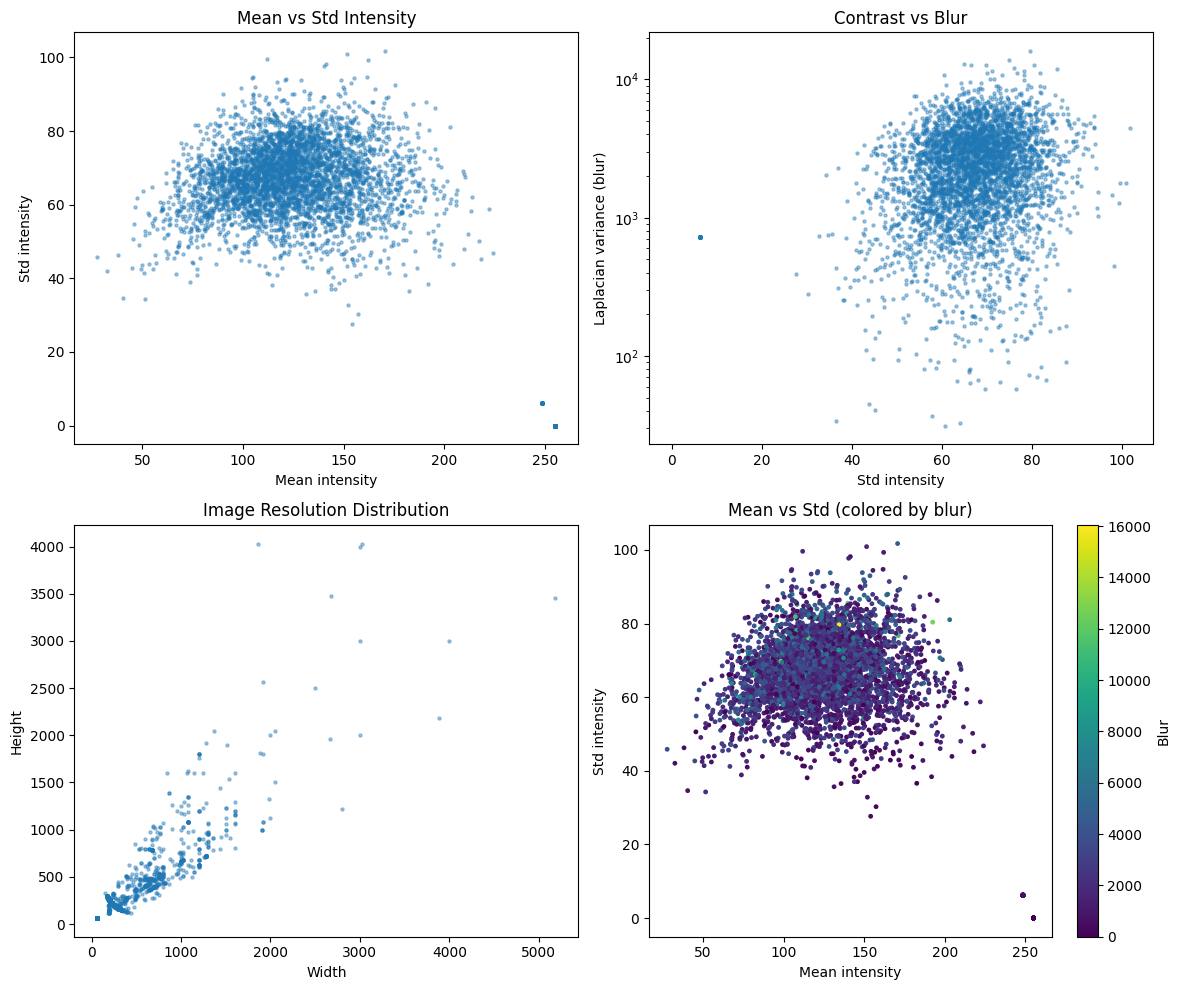

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# (1) Mean vs Std
axs[0, 0].scatter(
    train_inspect_df["mean"],
    train_inspect_df["std"],
    s=5,
    alpha=0.4
)
axs[0, 0].set_xlabel("Mean intensity")
axs[0, 0].set_ylabel("Std intensity")
axs[0, 0].set_title("Mean vs Std Intensity")

# (2) Std vs Blur
axs[0, 1].scatter(
    train_inspect_df["std"],
    train_inspect_df["blur"],
    s=5,
    alpha=0.4
)
axs[0, 1].set_xlabel("Std intensity")
axs[0, 1].set_ylabel("Laplacian variance (blur)")
axs[0, 1].set_yscale("log")
axs[0, 1].set_title("Contrast vs Blur")

# (3) Width vs Height
axs[1, 0].scatter(
    train_inspect_df["width"],
    train_inspect_df["height"],
    s=5,
    alpha=0.4
)
axs[1, 0].set_xlabel("Width")
axs[1, 0].set_ylabel("Height")
axs[1, 0].set_title("Image Resolution Distribution")

# (4) Mean vs Std colored by Blur
sc = axs[1, 1].scatter(
    train_inspect_df["mean"],
    train_inspect_df["std"],
    c=train_inspect_df["blur"],
    cmap="viridis",
    s=6
)
axs[1, 1].set_xlabel("Mean intensity")
axs[1, 1].set_ylabel("Std intensity")
axs[1, 1].set_title("Mean vs Std (colored by blur)")
fig.colorbar(sc, ax=axs[1, 1], label="Blur")

plt.tight_layout()
plt.show()

In [6]:
sus_mean = train_inspect_df[(train_inspect_df["mean"] >= 240) & (train_inspect_df["std"] <= 15)]

print("Suspicious mean and std range length:", len(sus_mean), end = "\n\n")
print(sus_mean.drop(columns=["filepath"]).head(), end="\n\n")
print(sus_mean[["mean","std","blur","width","height"]].describe())

Suspicious mean and std range length: 200

     width  height  aspect_ratio   mean  std  blur
34      64      64           1.0  255.0  0.0   0.0
49      64      64           1.0  255.0  0.0   0.0
54      64      64           1.0  255.0  0.0   0.0
110     64      64           1.0  255.0  0.0   0.0
112     64      64           1.0  255.0  0.0   0.0

             mean         std        blur  width  height
count  200.000000  200.000000  200.000000  200.0   200.0
mean   253.688005    1.243425  144.641785   64.0    64.0
std      2.630576    2.493091  290.009502    0.0     0.0
min    248.440023    0.000000    0.000000   64.0    64.0
25%    255.000000    0.000000    0.000000   64.0    64.0
50%    255.000000    0.000000    0.000000   64.0    64.0
75%    255.000000    0.000000    0.000000   64.0    64.0
max    255.000000    6.217126  723.208923   64.0    64.0


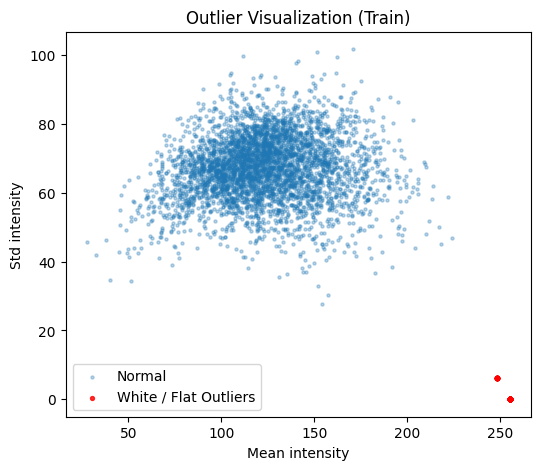

In [7]:
train_plot = train_inspect_df.set_index("filepath")
sus_plot = sus_mean.set_index("filepath")

before_df = train_plot
after_df = train_plot.drop(index=sus_plot.index)

plt.figure(figsize=(6,5))
plt.scatter(
    before_df["mean"],
    before_df["std"],
    s=5,
    alpha=0.3,
    label="Normal"
)
plt.scatter(
    sus_mean["mean"],
    sus_mean["std"],
    s=8,
    alpha=0.8,
    color="red",
    label="White / Flat Outliers"
)
plt.xlabel("Mean intensity")
plt.ylabel("Std intensity")
plt.title("Outlier Visualization (Train)")
plt.legend()
plt.show()

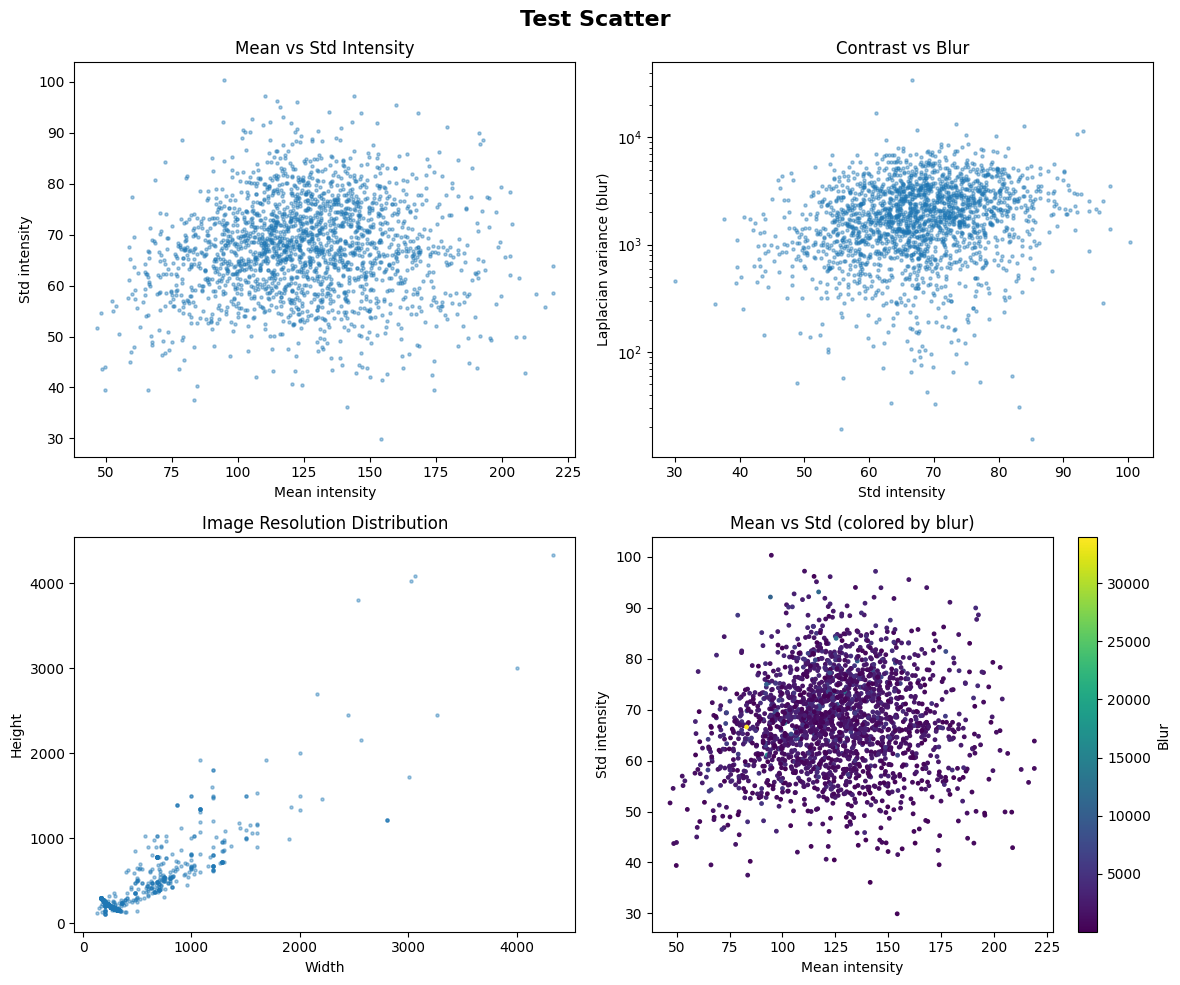

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# (1) Mean vs Std
axs[0, 0].scatter(
    test_inspect_df["mean"],
    test_inspect_df["std"],
    s=5,
    alpha=0.4
)
axs[0, 0].set_xlabel("Mean intensity")
axs[0, 0].set_ylabel("Std intensity")
axs[0, 0].set_title("Mean vs Std Intensity")

# (2) Std vs Blur
axs[0, 1].scatter(
    test_inspect_df["std"],
    test_inspect_df["blur"],
    s=5,
    alpha=0.4
)
axs[0, 1].set_xlabel("Std intensity")
axs[0, 1].set_ylabel("Laplacian variance (blur)")
axs[0, 1].set_yscale("log")
axs[0, 1].set_title("Contrast vs Blur")

# (3) Width vs Height
axs[1, 0].scatter(
    test_inspect_df["width"],
    test_inspect_df["height"],
    s=5,
    alpha=0.4
)
axs[1, 0].set_xlabel("Width")
axs[1, 0].set_ylabel("Height")
axs[1, 0].set_title("Image Resolution Distribution")

# (4) Mean vs Std colored by Blur
sc = axs[1, 1].scatter(
    test_inspect_df["mean"],
    test_inspect_df["std"],
    c=test_inspect_df["blur"],
    cmap="viridis",
    s=6
)
axs[1, 1].set_xlabel("Mean intensity")
axs[1, 1].set_ylabel("Std intensity")
axs[1, 1].set_title("Mean vs Std (colored by blur)")
fig.colorbar(sc, ax=axs[1, 1], label="Blur")

plt.suptitle("Test Scatter", weight="bold", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
valid_train_paths = [path for path in train_paths if path not in sus_mean.filepath.values]
print("Valid train image paths count:", len(valid_train_paths))

Valid train image paths count: 4057


In [10]:
import hashlib

def md5_hash(path, chunk_size=8192):
    md5 = hashlib.md5()
    with open(path, "rb") as f:
        while chunk := f.read(chunk_size):
            md5.update(chunk)
    return md5.hexdigest()

all_paths = valid_train_paths + test_good
hash_to_paths = {}

for p in tqdm(all_paths):
    h = md5_hash(p)
    hash_to_paths.setdefault(h, []).append(p)

duplicates = {
    h: ps for h, ps in hash_to_paths.items()
    if len(ps) > 1
}

print("Duplicated cluster size:", len(duplicates))

train_set = set(valid_train_paths)
test_set  = set(test_good)

train_train_dup = []
test_test_dup   = []
train_test_dup  = []

for paths in duplicates.values():
    paths = set(paths)
    if paths & train_set and paths & test_set:
        train_test_dup.append(paths)
    elif paths <= train_set:
        train_train_dup.append(paths)
    elif paths <= test_set:
        test_test_dup.append(paths)

print("\nTrain duplicated with train:", len(train_train_dup))
print("Train duplicated with test :", len(train_test_dup))
print("Test duplicated with test  :", len(train_test_dup))

100%|██████████| 6114/6114 [00:04<00:00, 1253.21it/s]

Duplicated cluster size: 6

Train duplicated with train: 5
Train duplicated with test : 0
Test duplicated with test  : 0


In [11]:
import imagehash
from itertools import combinations

def compute_phash(paths):
    phashes = {}
    for p in tqdm(paths):
        try:
            with Image.open(p) as img:
                phashes[p] = imagehash.phash(img)
        except Exception:
            phashes[p] = None
    return phashes

phash_dict = compute_phash(all_paths)
NEAR_DUP_THRESHOLD = 9

near_duplicates = []
paths = list(phash_dict.keys())

for i in tqdm(range(len(paths))):
    p1 = paths[i]
    h1 = phash_dict[p1]
    if h1 is None:
        continue

    for j in range(i + 1, len(paths)):
        p2 = paths[j]
        h2 = phash_dict[p2]
        if h2 is None:
            continue

        dist = h1 - h2
        if dist <= NEAR_DUP_THRESHOLD:
            near_duplicates.append((p1, p2, dist))

100%|██████████| 6114/6114 [00:52<00:00, 116.06it/s]


In [12]:
from collections import defaultdict

parent = {}

def find(x):
    parent.setdefault(x, x)
    if parent[x] != x:
        parent[x] = find(parent[x])
    return parent[x]

def union(x, y):
    px, py = find(x), find(y)
    if px != py:
        parent[py] = px

for p1, p2, _ in near_duplicates:
    union(p1, p2)

clusters = defaultdict(list)
for p in parent:
    clusters[find(p)].append(p)

near_dup_clusters = [c for c in clusters.values() if len(c) > 1]

print("Near-duplicate clusters:", len(near_dup_clusters))

train_set = set(valid_train_paths)
test_set  = set(test_good)

tt = []
tr_te = []
te_te = []

for cluster in near_dup_clusters:
    s = set(cluster)
    if s & train_set and s & test_set:
        tr_te.append(cluster)
    elif s <= train_set:
        tt.append(cluster)
    elif s <= test_set:
        te_te.append(cluster)

print("Train–Train near dup:", len(tt))
print("Train–Test near dup :", len(tr_te))
print("Test–Test near dup  :", len(te_te))

Near-duplicate clusters: 251
Train–Train near dup: 122
Train–Test near dup : 101
Test–Test near dup  : 28


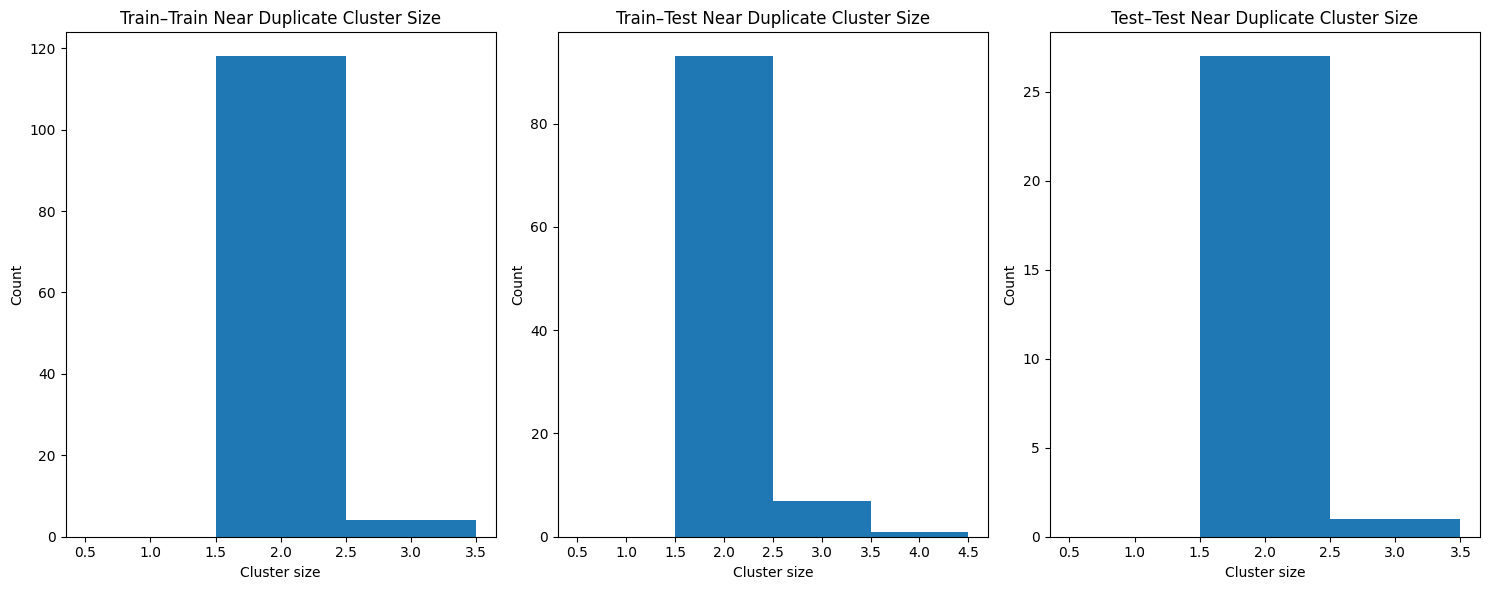

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

def plot_cluster_size(clusters, title, ax):
    sizes = [len(c) for c in clusters]

    ax.hist(sizes, bins=range(1, max(sizes)+2), align="left")
    ax.set_xlabel("Cluster size")
    ax.set_ylabel("Count")
    ax.set_title(title)

plot_cluster_size(tt,    "Train–Train Near Duplicate Cluster Size", ax1)
plot_cluster_size(tr_te, "Train–Test Near Duplicate Cluster Size", ax2)
plot_cluster_size(te_te, "Test–Test Near Duplicate Cluster Size", ax3)

plt.tight_layout()
plt.show()

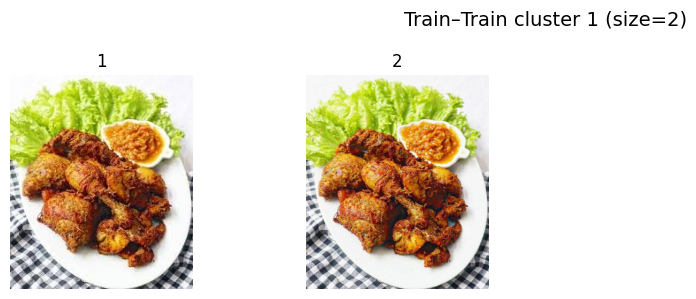

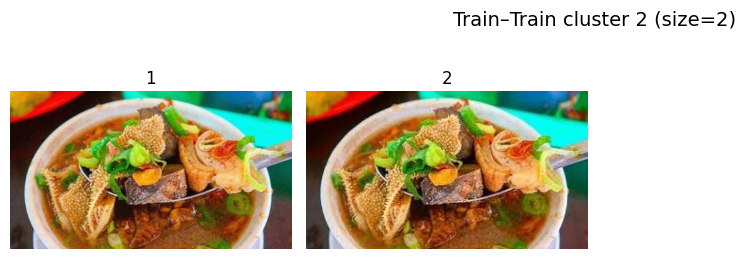

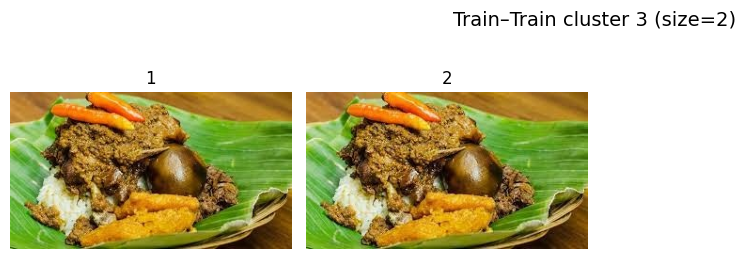

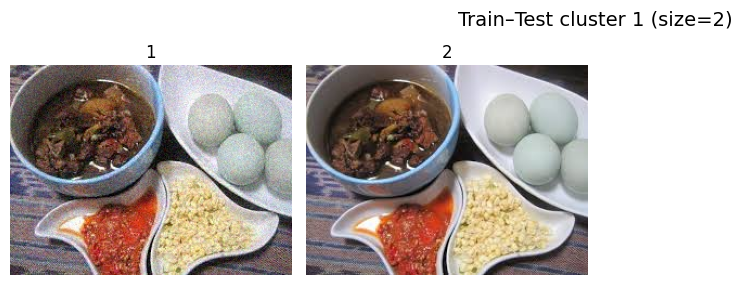

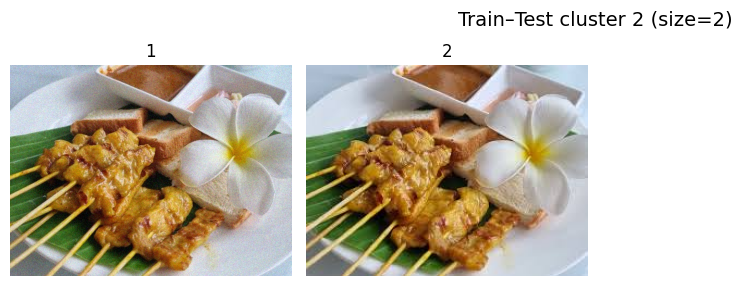

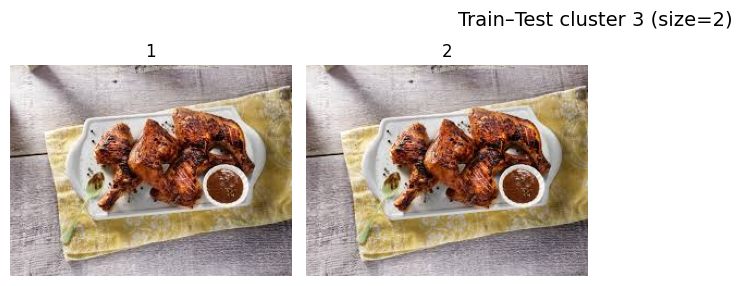

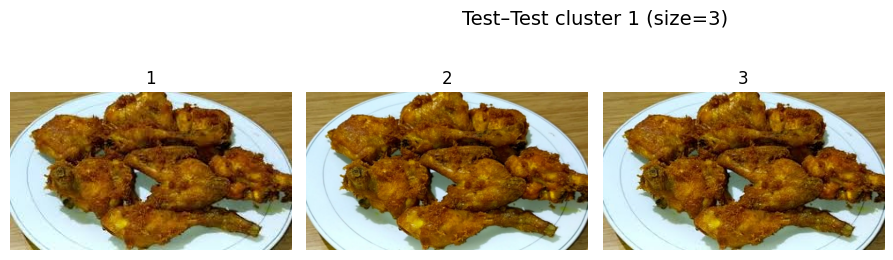

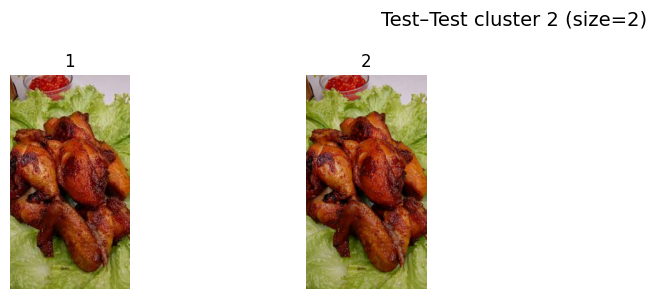

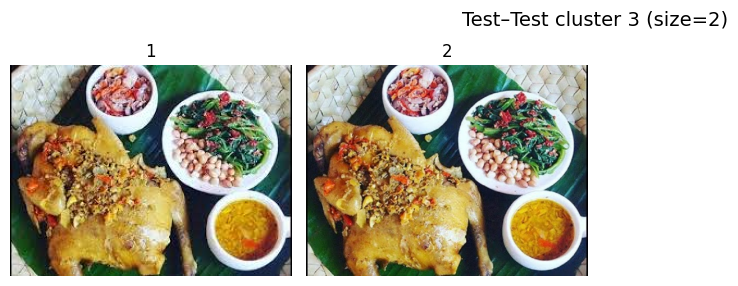

In [14]:
def show_cluster(cluster, max_show=12, title=None):
    paths = cluster[:max_show]
    n = len(paths)
    cols = 4
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols*3, rows*3))
    for i, p in enumerate(paths):
        img = Image.open(p).convert("RGB")
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"{i+1}")
        plt.axis("off")

    if title:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def inspect_random_clusters(clusters, k=3, name=""):
    sample = random.sample(clusters, min(k, len(clusters)))
    for i, c in enumerate(sample, 1):
        show_cluster(c, title=f"{name} cluster {i} (size={len(c)})")

inspect_random_clusters(tt,    k=3, name="Train–Train")
inspect_random_clusters(tr_te, k=3, name="Train–Test")
inspect_random_clusters(te_te, k=3, name="Test–Test")

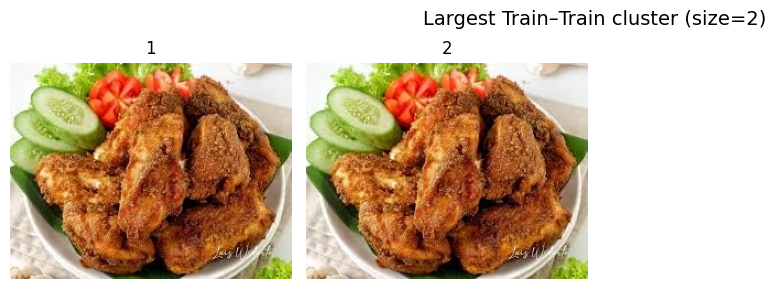

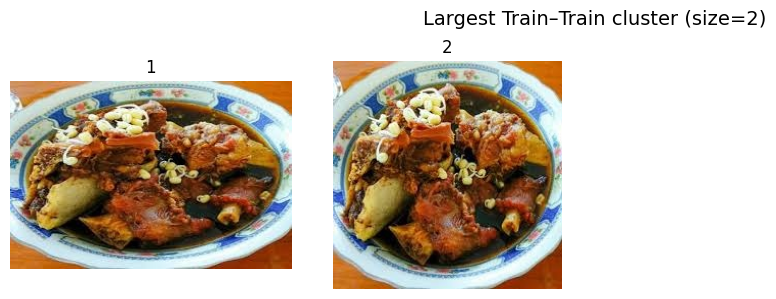

In [15]:
tt_sorted = sorted(tt, key=len, reverse=True)

for c in tt_sorted[-2:]:
    show_cluster(c, title=f"Largest Train–Train cluster (size={len(c)})")

In [16]:
df = train_inspect_df.set_index("filepath")

df["area"] = df["width"] * df["height"]
df["aspect_norm"] = df["aspect_ratio"].apply(lambda x: max(x, 1/x))

def pick_best_image(cluster, df):
    sub = df.loc[cluster].copy()
    sub = sub.sort_values(
        by=["aspect_norm", "area"],
        ascending=[True, False]
    )

    best = sub.index[0]
    dropped = sub.index[1:].tolist()
    return best, dropped

best_images = []
dropped_images = []

for cluster in tt:
    best, dropped = pick_best_image(cluster, df)
    best_images.append(best)
    dropped_images.extend(dropped)

print("Keep :", len(best_images))
print("Drop :", len(dropped_images))

Keep : 122
Drop : 126


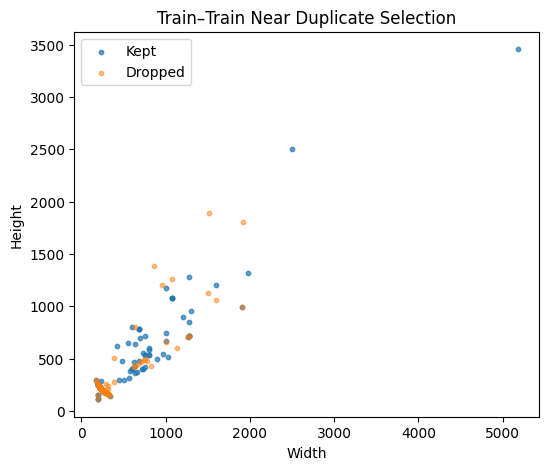

In [17]:
plt.figure(figsize=(6,5))

plt.scatter(
    df.loc[best_images, "width"],
    df.loc[best_images, "height"],
    s=10,
    alpha=0.7,
    label="Kept"
)

plt.scatter(
    df.loc[dropped_images, "width"],
    df.loc[dropped_images, "height"],
    s=10,
    alpha=0.5,
    label="Dropped"
)

plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Train–Train Near Duplicate Selection")
plt.legend()
plt.show()

In [18]:
train_final = [path for path in valid_train_paths if path not in dropped_images]
print("Train final shape:", len(train_final))

Train final shape: 3931


# **Sampling**

In [19]:
# Sample for semi supervised learning
samples = {
    "Ayam Bakar": [
        'zt93li.jpg','ztaz8z.jpg','zd4bwe.jpg','zgp5q9.jpg','ytcwjz.jpg',
        'ywtpui.jpg','ywx5mg.jpg','z0zm3z.jpg','irh22j.jpg','ifc83g.jpg',
        'hzgnpg.jpg','o7ulw5.jpg','hop7y8.jpg','gr31o3.jpg','ga7agq.jpg',
        'gdl2m4.jpg','g3p5t6.jpg','g3qflx.jpg','d4rzqt.jpg','axnqbt.jpg'
    ],
    "Ayam Betutu": [
        'ygu7z3.jpg','ypqd48.jpg','xfqise.jpg','vt92ep.jpg','vd7urd.jpg',
        'upblhd.jpg','udzjtt.jpg','tv0eau.jpg','o30wxz.jpg','ljwlzv.jpg',
        'zcizei.jpg','yzqjn8.jpg','oetw8i.jpg','nw6y1a.jpg','kwuynu.jpg',
        'n3jkct.jpg','mtbsd6.jpg','mcj9m3.jpg','mbij5m.jpg','ly0p05.jpg'
    ],
    "Ayam Goreng": [
        'osjvxg.jpg','qujnw0.jpg','zhn32w.jpg','z07piz.jpg','y4lvap.jpg',
        'ycdac0.jpg','xdb8lm.jpg','vw34ya.jpg','nn6ekv.jpg','nquemu.jpg',
        'n705xf.jpg','mex70x.jpg','mkquio.jpg','m3trfn.jpg','lll7ke.jpg',
        'g1ln16.jpg','kykkwi.jpg','l0nnmu.jpg','k0kqf4.jpg','kanelc.jpg'
    ],
    "Ayam Pop": [
        'oou5up.jpg','odz928.jpg','nustdy.jpg','o2l1hx.jpg','mxav50.jpg',
        'n31rta.jpg','n228a6.jpg','morqij.jpg','zsmnpe.jpg','zfwsk9.jpg',
        'z1v1f8.jpg','z4amw4.jpg','z5o4n2.jpg','z34eni.jpg','z60vs6.jpg',
        'yn0078.jpg','y7rkto.jpg','y7iwu2.jpg','xctf80.jpg','w3wsz2.jpg'
    ],
    "Bakso": [
        'muqjiv.jpg','m0q8mr.jpg','lklwlp.jpg','ln8hpq.jpg','lpbmcl.jpg',
        'lor0kr.jpg','lcqd98.jpg','kz1ptl.jpg','zw2rjh.jpg','znxlpx.jpg',
        'z9nnkd.jpg','zax7cb.jpg','zdkruq.jpg','ysz8wk.jpg','yxwli2.jpg',
        'z6eglr.jpg','xslrlc.jpg','xbh5l4.jpg','xgeyg6.jpg','wk46zj.jpg'
    ],
    "Coto Makassar": [
        'l2v5k1.jpg','jvbwe8.jpg','j5jd2u.jpg','jb3t6o.jpg','i6kcfk.jpg',
        'h71uty.jpg','fonqs2.jpg','ex3qjn.jpg','zte3xr.jpg','ztqgfl.jpg',
        'y9evk4.jpg','xavqmm.jpg','wzggze.jpg','x57avf.jpg','vgocao.jpg',
        'vlcfwi.jpg','vnwxs5.jpg','uxr2zd.jpg','uor0sm.jpg','u1os5m.jpg'
    ],
    "Gado Gado": [
        '9skpi5.jpg','9ro9eh.jpg','9x8owp.jpg','91lz87.jpg','8qchfx.jpg',
        '8s6kf8.jpg','8exb87.jpg','84mj9v.jpg','zh6js1.jpg','ysr9ym.jpg',
        'z0es0r.jpg','ykk3lw.jpg','ycu9wz.jpg','xk9k4m.jpg','wwxbjf.jpg',
        'we5nwp.jpg','wfz75c.jpg','vhgf0s.jpg','u3fvs6.jpg','tsl7bd.jpg'
    ],

    "Gudeg": [
        'wgnpok.jpg','vqrbrp.jpg','vs2xna.jpg','vttgn3.jpg','vwrsky.jpg',
        'w6yn02.jpg','uxl04w.jpg','v5hi5e.jpg','su8rbx.jpg','sx8sh7.jpg',
        's6v0d4.jpg','qyg63n.jpg','posxbw.jpg','pcfzp4.jpg','pci4oj.jpg',
        'oyr468.jpg','mv4g7m.jpg','jls4p0.jpg','jdrt61.jpg','jeqyd8.jpg'
    ],
    "Nasi Goreng": [
        'x7lih8.jpg','uj8i6c.jpg','xdeqr5.jpg','19icyo.jpg','11z4yt.jpg',
        '0aiagz.jpg','5bsfov.jpg','zyvkir.jpg','yp351h.jpg','z81cp5.jpg',
        'zinra3.jpg','2e7igv.jpg','1v9bz6.jpg','1dtrgj.jpg','0i9h44.jpg',
        '0i1gxc.jpg','0cczsl.jpg','0bh6sh.jpg','00sv9l.jpg','4427yo.jpg'
    ],

    "Pempek": [
        'ye59oz.jpg','ypg62x.jpg','zprbi0.jpg','915nvv.jpg','9whi9y.jpg',
        '8x53sf.jpg','7ufolm.jpg','xg9068.jpg','ycxjkl.jpg','wq8hfg.jpg',
        'qe20dk.jpg','5bogwu.jpg','4mc4wr.jpg','4kfq4b.jpg','3yrmom.jpg',
        '99856s.jpg','9w4enl.jpg','9resvi.jpg','7mrby1.jpg','7c0l6c.jpg'
    ],
    "rawon": [
        'zp5smb.jpg','vq96ba.jpg','y13sh9.jpg','3w3poi.jpg','68mly1.jpg',
        '8zaug5.jpg','a6ovv0.jpg','xaibrr.jpg','xf8pf8.jpg','xe09c4.jpg',
        'ygd37o.jpg','06ni3h.jpg','6ualqk.jpg','bx0fdi.jpg','bpd5rj.jpg',
        'b7z0dj.jpg','hkpad9.jpg','epek9v.jpg','emdrz5.jpg','m1k2x8.jpg'
    ],
    "Rendang": [
        'r1dwjr.jpg','n7nm4v.jpg','oyiy5b.jpg','5596vl.jpg','9hlfxr.jpg',
        '8harg6.jpg','7sdrcv.jpg','tqw5kn.jpg','tklbvc.jpg','q7izrp.jpg',
        'treiw0.jpg','230e1n.jpg','29u1i4.jpg','05rl1p.jpg','2g9yhj.jpg',
        '1z746f.jpg','1ws386.jpg','5koy6m.jpg','2jynpg.jpg','3c68du.jpg'
    ],

    "Sate Madura": [
        't2rvsa.jpg','souf92.jpg','rxjuqb.jpg','073u7f.jpg','17zxr8.jpg',
        'xkgods.jpg','5ytesw.jpg','sj0bdq.jpg','sfdgq3.jpg','sabp9v.jpg',
        'ru4er4.jpg','274329.jpg','044hgc.jpg','134ovu.jpg','27h8hs.jpg',
        '40ma7s.jpg','38ccq9.jpg','30v05m.jpg','5u89p9.jpg','4voy9c.jpg'
    ],
    "Sate Padang": [
        'io72zl.jpg','jjpnkj.jpg','jmgp9d.jpg','0us23t.jpg','0ulszd.jpg',
        '0pnjze.jpg','9xwtq3.jpg','i2v6f7.jpg','ibb7np.jpg','oaaxob.jpg',
        'pu3gos.jpg','19tv5c.jpg','400eom.jpg','5bchh9.jpg','846gqq.jpg',
        '80evge.jpg','73wypf.jpg','8xwlpp.jpg','8he9j8.jpg','7pjfqb.jpg'
    ],
    "Soto": [
        'dlt2qa.jpg','a44jun.jpg','ajy0b6.jpg','6tu7qi.jpg','bxm43j.jpg',
        'j6jy3n.jpg','py8rv7.jpg','g52zkp.jpg','ga5p62.jpg','h0plhm.jpg',
        'hi7ohy.jpg','6ln0r0.jpg','c8j0xd.jpg','a44jun.jpg','gltm2j.jpg',
        'ggve3n.jpg','ke5qc7.jpg','k68gfn.jpg','iqonfz.jpg','i1pnbe.jpg'
    ],
}

label2id = {label: i for i, label in enumerate(samples.keys())}
id2label = {i: label for label, i in label2id.items()}

print("Label mapping:")
for idx, label_str in id2label.items():
    print(f"{idx:2d} -> {label_str}")

Label mapping:
 0 -> Ayam Bakar
 1 -> Ayam Betutu
 2 -> Ayam Goreng
 3 -> Ayam Pop
 4 -> Bakso
 5 -> Coto Makassar
 6 -> Gado Gado
 7 -> Gudeg
 8 -> Nasi Goreng
 9 -> Pempek
10 -> rawon
11 -> Rendang
12 -> Sate Madura
13 -> Sate Padang
14 -> Soto


In [20]:
dropped_filenames = {Path(p).name for p in dropped_images}
affected_samples = []

for label, filenames in samples.items():
    for fname in filenames:
        if fname in dropped_filenames:
            affected_samples.append((label, fname))

print("Dropped samples:", len(affected_samples))
affected_samples[:10]

Dropped samples: 12


[('Ayam Bakar', 'zt93li.jpg'),
 ('Ayam Bakar', 'ytcwjz.jpg'),
 ('Ayam Betutu', 'o30wxz.jpg'),
 ('Ayam Goreng', 'kykkwi.jpg'),
 ('Ayam Pop', 'mxav50.jpg'),
 ('Coto Makassar', 'j5jd2u.jpg'),
 ('Gudeg', 'su8rbx.jpg'),
 ('Gudeg', 'sx8sh7.jpg'),
 ('Nasi Goreng', '1v9bz6.jpg'),
 ('Rendang', '2jynpg.jpg')]

In [21]:
drop_to_keep = {}

for cluster in tt:
    kept = [p for p in cluster if p in best_images]
    dropped = [p for p in cluster if p in dropped_images]

    if len(kept) == 1:
        k = kept[0]
        for d in dropped:
            drop_to_keep[d] = k
            
filename_drop_to_keep = {
    Path(drop).name: Path(keep).name
    for drop, keep in drop_to_keep.items()
}

replaced = []

for label, filenames in samples.items():
    new_filenames = []
    for fname in filenames:
        if fname in filename_drop_to_keep:
            new_fname = filename_drop_to_keep[fname]
            new_filenames.append(new_fname)
            replaced.append((label, fname, new_fname))
        else:
            new_filenames.append(fname)
    samples[label] = new_filenames

replaced

[('Ayam Bakar', 'zt93li.jpg', '52jxyy.jpg'),
 ('Ayam Bakar', 'ytcwjz.jpg', 'ybcral.jpg'),
 ('Ayam Betutu', 'o30wxz.jpg', 'dokiiq.jpg'),
 ('Ayam Goreng', 'kykkwi.jpg', '0axw50.jpg'),
 ('Ayam Pop', 'mxav50.jpg', 'tq629y.jpg'),
 ('Coto Makassar', 'j5jd2u.jpg', 'gcw7kj.jpg'),
 ('Gudeg', 'su8rbx.jpg', 'qycmkm.jpg'),
 ('Gudeg', 'sx8sh7.jpg', 'vqrbrp.jpg'),
 ('Nasi Goreng', '1v9bz6.jpg', 'smpcp8.jpg'),
 ('Rendang', '2jynpg.jpg', '4m2hxo.jpg'),
 ('Sate Madura', '073u7f.jpg', 'mxbxb7.jpg'),
 ('Sate Madura', '40ma7s.jpg', 'n37u36.jpg')]

In [22]:
rows = []

for label, files in samples.items():
    for fname in files:
        rows.append({
            "filepath": train_dir/fname,
            "pred": label
        })

sample_df = pd.DataFrame(rows)
print("Samples shape:", sample_df.shape)
print(sample_df.head())

sample_df["pred"] = sample_df["pred"].map(label2id)
print("\nSamples label mapped!")

Samples shape: (300, 2)
                                            filepath        pred
0  /kaggle/input/data-mining-action-2025/train/tr...  Ayam Bakar
1  /kaggle/input/data-mining-action-2025/train/tr...  Ayam Bakar
2  /kaggle/input/data-mining-action-2025/train/tr...  Ayam Bakar
3  /kaggle/input/data-mining-action-2025/train/tr...  Ayam Bakar
4  /kaggle/input/data-mining-action-2025/train/tr...  Ayam Bakar

Samples label mapped!


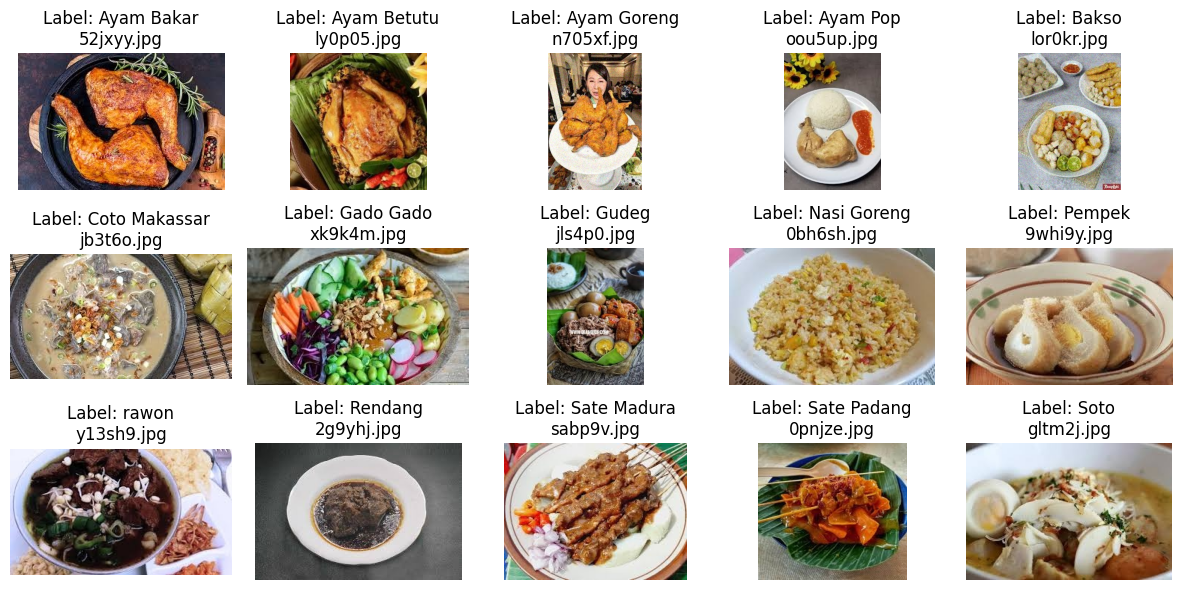

In [23]:
sample_plot = (
    sample_df
    .groupby("pred")
    .sample(n=1)
    .sort_values("pred")
    .reset_index(drop=True)
)

fig, axes = plt.subplots(3, 5, figsize=(12, 6))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample_plot.iterrows()):
    img = Image.open(row["filepath"]).convert("RGB")
    ax.imshow(img)
    ax.set_title(f"Label: {id2label[row['pred']]}\n{row['filepath'].name}")
    ax.axis("off")

for ax in axes[len(sample_df):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# **Train and Test Final Set**

In [24]:
full_train_df = pd.DataFrame({"filepath": train_final})
train_df      = full_train_df.merge(sample_df, on="filepath", how="left")
train_df      = train_df[np.isnan(train_df["pred"])].drop(columns=["pred"])

test_df = pd.DataFrame({"filepath": test_paths})

full_train_ext_count = Counter(p.suffix.lower() for p in full_train_df["filepath"])
train_ext_count      = Counter(p.suffix.lower() for p in train_df["filepath"])
test_ext_count       = Counter(p.suffix.lower() for p in test_df["filepath"])

print(train_df.head())
print("\nFull train format          :", dict(full_train_ext_count))
print("Full train length          :", len(full_train_df))
print("Train without sample format:", dict(train_ext_count))
print("Train without sample length:", len(train_df))

print(test_df.head())
print("\nTest format breakdown:", dict(test_ext_count))
print("Test length          :", len(test_df))

                                            filepath
0  /kaggle/input/data-mining-action-2025/train/tr...
1  /kaggle/input/data-mining-action-2025/train/tr...
2  /kaggle/input/data-mining-action-2025/train/tr...
3  /kaggle/input/data-mining-action-2025/train/tr...
4  /kaggle/input/data-mining-action-2025/train/tr...

Full train format          : {'.jpg': 3931}
Full train length          : 3931
Train without sample format: {'.jpg': 3633}
Train without sample length: 3633
                                            filepath
0  /kaggle/input/data-mining-action-2025/test/tes...
1  /kaggle/input/data-mining-action-2025/test/tes...
2  /kaggle/input/data-mining-action-2025/test/tes...
3  /kaggle/input/data-mining-action-2025/test/tes...
4  /kaggle/input/data-mining-action-2025/test/tes...

Test format breakdown: {'.jpg': 1787, '.png': 270}
Test length          : 2057


In [25]:
print("Constructing dataset class...")
class ImageDataset(Dataset):
    def __init__(self, df, transform=None, with_label=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.with_label = with_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filepath = self.df.loc[idx, "filepath"]
        img = Image.open(filepath).convert("RGB")
        
        if self.transform:
            img = self.transform(img)

        if self.with_label:
            label = int(self.df.loc[idx, "pred"])
            return img, label, str(filepath)
        else:
            return img, str(filepath)
        
print("Build train loadet...")

std =[0.229, 0.224, 0.225]
mean=[0.485, 0.456, 0.406]

train_transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset  = ImageDataset(train_df, transform=train_transform)
test_dataset   = ImageDataset(test_df, transform=test_transform)
sample_dataset = ImageDataset(sample_df, transform=train_transform, with_label=True)

sample_img, idx_sample, sample_path = sample_dataset[0]

print("\nSample path       :", sample_path)
print("Sample label      :", id2label[idx_sample])
print("Sample image shape:", sample_img.shape)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=0
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=0
)
sample_loader = DataLoader(
    sample_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=0
)

train_batch, _ = next(iter(train_loader))
test_batch, _ = next(iter(test_loader))

print("\nTrain batch shape:", train_batch.shape)
print("Test batch shape :", test_batch.shape)

print("\nNumber of batch train loader:", len(train_loader))
print("Number of batch test loader :", len(test_loader))

print("\nLoader all set!")

Constructing dataset class...
Build train loadet...

Sample path       : /kaggle/input/data-mining-action-2025/train/train/52jxyy.jpg
Sample label      : Ayam Bakar
Sample image shape: torch.Size([3, 224, 224])

Train batch shape: torch.Size([32, 3, 224, 224])
Test batch shape : torch.Size([32, 3, 224, 224])

Number of batch train loader: 114
Number of batch test loader : 65

Loader all set!


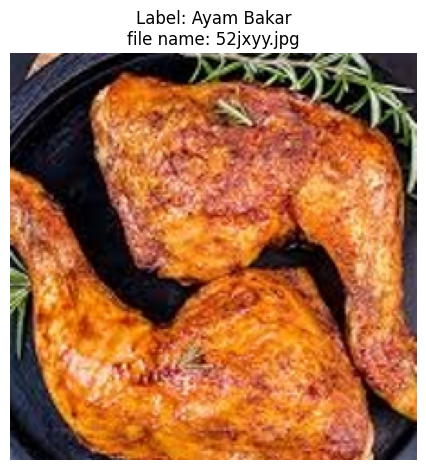

In [26]:
mean = torch.tensor([0.485, 0.456, 0.406])
std  = torch.tensor([0.229, 0.224, 0.225])

img = sample_img.permute(1, 2, 0) * std + mean

plt.imshow(img)
plt.axis("off")

plt.title(f"Label: {id2label[idx_sample]}\nfile name: {Path(sample_path).name}")
plt.tight_layout()
plt.show()

# **Embedding**

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dinov2 = torch.hub.load("facebookresearch/dinov2", 
                        "dinov2_vitb14")
dinov2.eval()
dinov2.to(device)

print("Loaded:", type(dinov2), "on", device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:01<00:00, 311MB/s]


Loaded: <class 'dinov2.models.vision_transformer.DinoVisionTransformer'> on cuda


In [28]:
import torch.nn.functional as F

@torch.no_grad()
def extract_embedding(batch_images: torch.Tensor) -> torch.Tensor:
    batch_images = batch_images.to(device, non_blocking=True)
    feats = dinov2(batch_images)
    feats = F.normalize(feats, p=2, dim=1)
    return feats

images, labels, filepath = next(iter(sample_loader))
emb = extract_embedding(images)

print("batch shape :", images.shape)
print("embedding   :", emb.shape)
print("labels      :", labels[:10])

batch shape : torch.Size([32, 3, 224, 224])
embedding   : torch.Size([32, 768])
labels      : tensor([11, 11, 14, 12, 13, 14,  8,  8,  2,  8])


In [29]:
print("Embeddings Images...")
dinov2.eval()

with torch.no_grad():
    print("\nEmbedding each class from samples...")
    sample_embeddings = defaultdict(list)
    
    for images, labels, _ in tqdm(sample_loader, desc="Embedding...", unit="batch"):
        emb = extract_embedding(images)
        labels = labels.cpu()

        for embedding, label in zip(emb, labels):
            sample_embeddings[int(label)].append(embedding.cpu())

    print("\nEmbedding train data...")
    train_embeddings = []
    
    for images, filepaths in tqdm(train_loader):
        emb = extract_embedding(images)

        for embedding, filepath in zip(emb, filepaths):
            train_embeddings.append({
                "emb": embedding.cpu(),
                "filepath": filepath,
                "source": "train"
            })

    print("\nEmbedding test data...")
    test_embeddings = []
    
    for images, filepaths in tqdm(test_loader):
        emb = extract_embedding(images)

        for embedding, filepath in zip(emb, filepaths):
            test_embeddings.append({
                "emb": embedding.cpu(),
                "filepath": filepath,
                "source": "test"
            })

print("\nTrain embedding count:", len(train_embeddings))
print("Test embedding count :", len(test_embeddings))

print("\nFinish!")

Embeddings Images...

Embedding each class from samples...


Embedding...: 100%|██████████| 10/10 [00:05<00:00,  1.86batch/s]



Embedding train data...


100%|██████████| 114/114 [01:07<00:00,  1.70it/s]



Embedding test data...


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Train embedding count: 3633
Test embedding count : 2057

Finish!


In [30]:
prototypes = {}

print("Build prototypes...")
for cls, emb_list in tqdm(sample_embeddings.items(), desc="Building centroid for each class..."):
    emb_stack = torch.stack(emb_list)          # [Nc, D]
    centroid = emb_stack.mean(dim=0)           # [D]
    
    centroid = F.normalize(centroid, p=2, dim=0)
    prototypes[cls] = centroid

def cosine_sim(a, b):
    return torch.matmul(a, b)

correct = 0
total = 0

print("\nCalculating sample accuracy from centroid...")
for cls, emb_list in sample_embeddings.items():
    proto = prototypes[cls]
    for e in emb_list:
        sims = {c: cosine_sim(e, p) for c, p in prototypes.items()}
        pred = max(sims, key=sims.get)
        correct += int(pred == cls)
        total += 1

print("\nTotal classes           :", len(prototypes))
print("Prototype dim           :", next(iter(prototypes.values())).shape)
print(f"Prototype self-accuracy : {correct}/{total} = {correct/total:.3f}")

Build prototypes...


Building centroid for each class...: 100%|██████████| 15/15 [00:00<00:00, 3636.89it/s]


Calculating sample accuracy from centroid...

Total classes           : 15
Prototype dim           : torch.Size([768])
Prototype self-accuracy : 284/300 = 0.947


Images embedded shape: torch.Size([300, 768]),
Labels embedded shape: torch.Size([300])


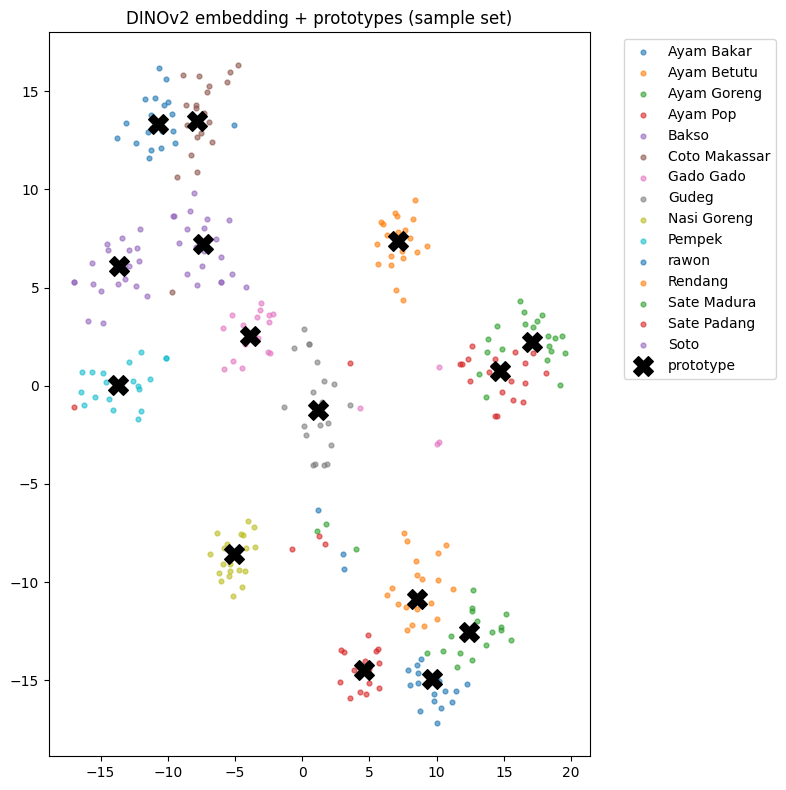

In [31]:
sample_emb_images, sample_emb_labels = [], []

for cls, emb_list in sample_embeddings.items():
    for e in emb_list:
        sample_emb_images.append(e)
        sample_emb_labels.append(cls)

sample_emb_images = torch.stack(sample_emb_images)   # [N, D]
sample_emb_labels = torch.tensor(sample_emb_labels)  # [N]

print(f"Images embedded shape: {sample_emb_images.shape},\n"\
      f"Labels embedded shape: {sample_emb_labels.shape}")

sample_images_np = sample_emb_images.cpu().numpy()
sample_labels_np = sample_emb_labels.cpu().numpy()

sample_proto_np = np.stack([p.cpu().numpy() for p in prototypes.values()])

X_sample = np.vstack([sample_images_np, sample_proto_np])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_sample_2d = tsne.fit_transform(X_sample)

X_sample_data = X_sample_2d[:len(sample_images_np)]
X_sample_proto = X_sample_2d[len(sample_images_np):]

plt.figure(figsize=(8, 8))
for c in np.unique(sample_labels_np):
    idx = sample_labels_np == c
    plt.scatter(
        X_sample_data[idx, 0],
        X_sample_data[idx, 1],
        s=12,
        alpha=0.6,
        label=id2label[c]
    )

plt.scatter(
    X_sample_proto[:, 0],
    X_sample_proto[:, 1],
    c="black",
    s=200,
    marker="X",
    label="prototype"
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("DINOv2 embedding + prototypes (sample set)")
plt.tight_layout()
plt.show()

# **Pseudo Labeling**

## **Iteration 1**

In [32]:
similarity_threshold_1 = 0.65
margin_threshold_1 = 0.15

print(f"Similarity threshold: {similarity_threshold_1} | Margin threshold: {margin_threshold_1}")

pseudo_images_1 = []
pseudo_labels_1 = []
stats = []

dinov2.eval()
with torch.no_grad():
    for batch, _ in tqdm(train_loader):
        images = batch[0] if isinstance(batch, (list, tuple)) else batch
        emb = extract_embedding(images)  # [B, D]

        # stack prototypes [C, D]
        proto_mat = torch.stack([p.to(emb.device) for p in prototypes.values()])
        proto_ids = list(prototypes.keys())

        # cosine similarity [B, C]
        sims = emb @ proto_mat.T

        top2_vals, top2_idx = sims.topk(2, dim=1)
        top1, top2 = top2_vals[:, 0], top2_vals[:, 1]
        
        margin = top1 - top2
        for i in range(len(images)):
            if top1[i] >= similarity_threshold_1 and margin[i] >= margin_threshold_1:
                pseudo_images_1.append(images[i].cpu())
                pseudo_labels_1.append(proto_ids[top2_idx[i, 0].item()])
                
                stats.append(top1[i].item())

print("Pseudo-labeled samples:", len(pseudo_labels_1))
print("Avg similarity        :", sum(stats) / len(stats))
print("Max similarity        :", max(stats))
print("Min similarity        :", min(stats))

Similarity threshold: 0.65 | Margin threshold: 0.15


100%|██████████| 114/114 [01:13<00:00,  1.56it/s]

Pseudo-labeled samples: 1085
Avg similarity        : 0.7440742082859514
Max similarity        : 0.9118489027023315
Min similarity        : 0.6502570509910583


In [33]:
X_pseudo_1 = []
y_pseudo_1 = []

print("Building pseudo label...")
with torch.no_grad():
    for images, label in tqdm(zip(pseudo_images_1, pseudo_labels_1)):
        emb = extract_embedding(images.unsqueeze(0))[0]
        
        X_pseudo_1.append(emb.cpu())
        y_pseudo_1.append(label)

X_pseudo_1 = torch.stack(X_pseudo_1)          
y_pseudo_1 = torch.tensor(y_pseudo_1)         

print("\nPseudo features shape:", X_pseudo_1.shape)
print("Pseudo labels shape  :", y_pseudo_1.shape)

Building pseudo label...


1085it [00:21, 49.58it/s]


Pseudo features shape: torch.Size([1085, 768])
Pseudo labels shape  : torch.Size([1085])


In [34]:
def stratified_split(class_embeddings, split_ratio=0.8, seed=42):
    random.seed(seed)
    train_X, train_y = [], []
    val_X, val_y = [], []

    for label, emb_list in class_embeddings.items():
        emb_list = emb_list.copy()
        random.shuffle(emb_list)
        n_train = int(len(emb_list) * split_ratio)

        for emb in emb_list[:n_train]:
            train_X.append(emb)
            train_y.append(label)

        for emb in emb_list[n_train:]:
            val_X.append(emb)
            val_y.append(label)

    return (
        torch.stack(train_X), torch.tensor(train_y),
        torch.stack(val_X), torch.tensor(val_y)
    )

print("Splitting train and validation from ground truth...")
X_train, y_train, X_val, y_val = stratified_split(sample_embeddings, split_ratio=0.5)

print("\nTrain features shape  :", X_train.shape)
print("Train labels shape    :", y_train.shape)
print("Val features shape    :", X_val.shape)
print("Val labels shape      :", y_val.shape)

X_train_1 = torch.cat([X_train, X_pseudo_1])
y_train_1 = torch.cat([y_train, y_pseudo_1])

print("\nTrain features shape  :", X_train_1.shape)
print("Train labels shape    :", y_train_1.shape)

dataset_train_1  = TensorDataset(X_train_1, y_train_1)

print("\nBuilding ground truth focused weight...")
is_pseudo = torch.zeros(len(y_train_1), dtype=torch.bool)
is_pseudo[150:] = True

class_count = Counter(y_train_1.tolist())

down_weight = 0.6
weights = []
for i, label in enumerate(y_train_1):
    w = 1.0 / class_count[int(label)]
    if is_pseudo[i]:
        w *= down_weight
    weights.append(w)

weights_train_1 = torch.tensor(weights)
sampler_train_1 = WeightedRandomSampler(
    weights_train_1, 
    num_samples = len(weights_train_1), 
    replacement = True
)

print("\nBuilding loader...")
loader_tr_1 = DataLoader(
    dataset_train_1, 
    batch_size=64, 
    sampler=sampler_train_1
)

dataset_val = TensorDataset(X_val, y_val)
loader_val = DataLoader(
    dataset_val,
    batch_size=32,
    shuffle=False
)
print("Finish!")

Splitting train and validation from ground truth...

Train features shape  : torch.Size([150, 768])
Train labels shape    : torch.Size([150])
Val features shape    : torch.Size([150, 768])
Val labels shape      : torch.Size([150])

Train features shape  : torch.Size([1235, 768])
Train labels shape    : torch.Size([1235])

Building ground truth focused weight...

Building loader...
Finish!


## **Training Head I**

In [35]:
def eval_epoch(model, criterion, loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * xb.size(0)
            preds = torch.argmax(logits, dim=1)

            correct += (preds == yb).sum().item()
            total += yb.size(0)

    return (
        total_loss / total,
        correct / total
    )

num_classes = 15
embed_dim   = X_pseudo_1.shape[1]

print(f"Head built with in features {embed_dim}, and out features {num_classes}")
head = nn.Linear(embed_dim, num_classes).to(device)

lr_1 = 1e-3
epochs_1 = 200

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(head.parameters(), lr=lr_1)

print(f"Training head with {epochs_1} epochs and learning rate {lr_1}\n")

train_loss_1, train_acc_1 =[], [] 
val_loss_1, val_acc_1 = [], []

for epoch in range(epochs_1):
    head.train()
    
    train_loss    = 0.0
    train_correct = 0
    train_total   = 0

    for xb, yb in loader_tr_1:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = head(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == yb).sum().item()
        train_total += yb.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    val_loss, val_acc = eval_epoch(
        head,
        criterion,
        loader_val,
        device
    )

    if (epoch + 1) % int(epochs_1/10) == 0:
        print(
            f"  Epoch {epoch+1:{len(str(epochs_1))}d} | "
            f"train loss: {train_loss:.4f} | train acc: {train_acc:.4f} | "
            f"val loss: {val_loss:.4f} | val acc: {val_acc:.4f}"
        )

    train_loss_1.append(train_loss)
    train_acc_1.append(train_acc)
    val_loss_1.append(val_loss)
    val_acc_1.append(val_acc)

print("\nTraining finished!")

Head built with in features 768, and out features 15
Training head with 200 epochs and learning rate 0.001

  Epoch  20 | train loss: 0.5845 | train acc: 0.9733 | val loss: 0.8156 | val acc: 0.8933
  Epoch  40 | train loss: 0.2291 | train acc: 0.9798 | val loss: 0.4896 | val acc: 0.9067
  Epoch  60 | train loss: 0.1461 | train acc: 0.9862 | val loss: 0.3746 | val acc: 0.9267
  Epoch  80 | train loss: 0.0984 | train acc: 0.9927 | val loss: 0.3154 | val acc: 0.9267
  Epoch 100 | train loss: 0.0625 | train acc: 0.9960 | val loss: 0.2770 | val acc: 0.9333
  Epoch 120 | train loss: 0.0507 | train acc: 0.9960 | val loss: 0.2492 | val acc: 0.9333
  Epoch 140 | train loss: 0.0378 | train acc: 0.9976 | val loss: 0.2307 | val acc: 0.9267
  Epoch 160 | train loss: 0.0276 | train acc: 0.9976 | val loss: 0.2166 | val acc: 0.9333
  Epoch 180 | train loss: 0.0210 | train acc: 1.0000 | val loss: 0.2064 | val acc: 0.9333
  Epoch 200 | train loss: 0.0190 | train acc: 1.0000 | val loss: 0.1974 | val acc:

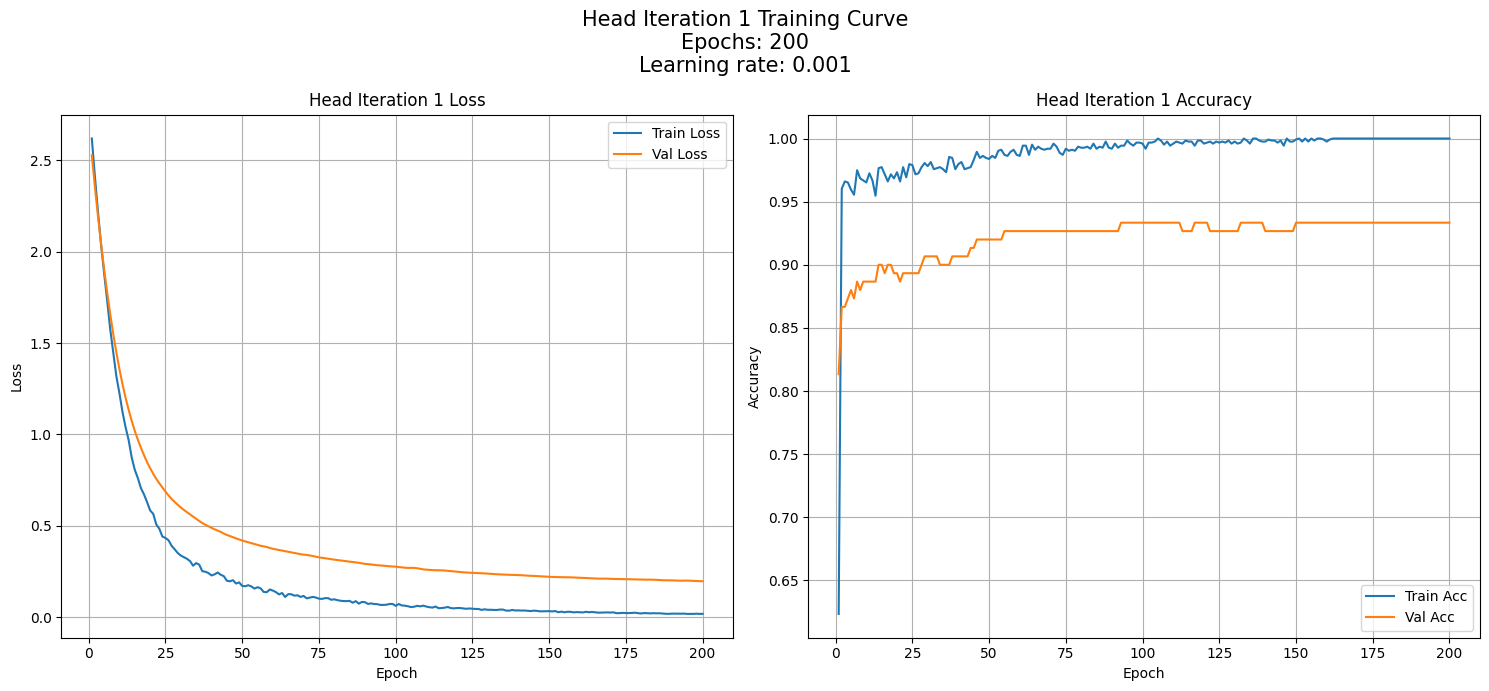

In [36]:
def plot_training_curves(
    train_loss, val_loss,
    train_acc, val_acc,
    lr, epoch,
    title_prefix="",
    suptitle = ""
):
    epochs = range(1, epoch + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Loss
    ax1.plot(epochs, train_loss, label="Train Loss")
    ax1.plot(epochs, val_loss, label="Val Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title(f"{title_prefix} Loss")
    ax1.legend()
    ax1.grid(True)
    
    #  Accuracy
    ax2.plot(epochs, train_acc, label="Train Acc")
    ax2.plot(epochs, val_acc, label="Val Acc")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_title(f"{title_prefix} Accuracy")
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(f"{suptitle}\nEpochs: {epoch}\nLearning rate: {lr}", fontsize=15)
    plt.tight_layout()
    plt.show()

plot_training_curves(
    train_loss_1, val_loss_1,
    train_acc_1,  val_acc_1,
    epoch = epochs_1, lr = lr_1,
    title_prefix = "Head Iteration 1",
    suptitle = "Head Iteration 1 Training Curve"
)

Calculating direct prototype evaluation...


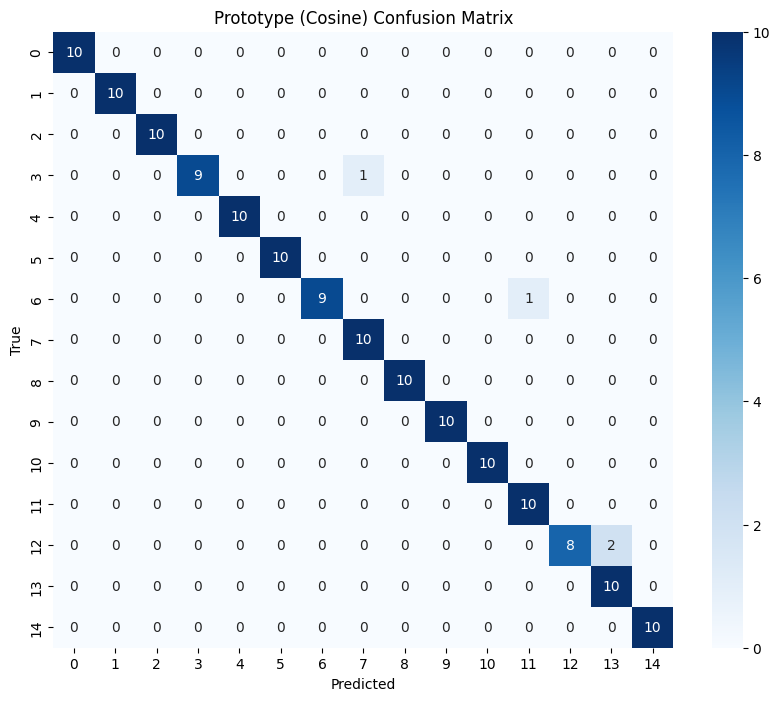

               precision    recall  f1-score   support

   Ayam Bakar       1.00      1.00      1.00        10
  Ayam Betutu       1.00      1.00      1.00        10
  Ayam Goreng       1.00      1.00      1.00        10
     Ayam Pop       1.00      0.90      0.95        10
        Bakso       1.00      1.00      1.00        10
Coto Makassar       1.00      1.00      1.00        10
    Gado Gado       1.00      0.90      0.95        10
        Gudeg       0.91      1.00      0.95        10
  Nasi Goreng       1.00      1.00      1.00        10
       Pempek       1.00      1.00      1.00        10
        rawon       1.00      1.00      1.00        10
      Rendang       0.91      1.00      0.95        10
  Sate Madura       1.00      0.80      0.89        10
  Sate Padang       0.83      1.00      0.91        10
         Soto       1.00      1.00      1.00        10

     accuracy                           0.97       150
    macro avg       0.98      0.97      0.97       150
 weighte

In [37]:
print("Calculating direct prototype evaluation...")

with torch.no_grad():
    proto_mat = torch.stack(list(prototypes.values())).to(device)   # (C, D)
    proto_ids = torch.tensor(list(prototypes.keys())).to(device)    # (C,)

    # optional tapi SANGAT disarankan kalau ini cosine similarity
    Xv = F.normalize(X_val.to(device), dim=1)
    P  = F.normalize(proto_mat, dim=1)

    sims  = Xv @ P.T                     # (N, C)
    preds = sims.argmax(dim=1)           # (N,)

    y_pred = proto_ids[preds].cpu().numpy()
    y_true = y_val.cpu().numpy()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Prototype (Cosine) Confusion Matrix")
plt.show()

class_names = [id2label[i] for i in sorted(prototypes.keys())]

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=2
))

In [38]:
def evaluate_and_collect_preds(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(yb.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()
    return y_true, y_pred

y_true, y_pred = evaluate_and_collect_preds(head, loader_val, device)

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 9  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  9  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  9  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  7  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  8  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  9  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  9]]


In [39]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=[id2label[i] for i in range(len(np.unique(y_true)))]
    )
)

               precision    recall  f1-score   support

   Ayam Bakar       0.90      0.90      0.90        10
  Ayam Betutu       0.91      1.00      0.95        10
  Ayam Goreng       0.90      0.90      0.90        10
     Ayam Pop       1.00      1.00      1.00        10
        Bakso       1.00      1.00      1.00        10
Coto Makassar       1.00      1.00      1.00        10
    Gado Gado       0.75      0.90      0.82        10
        Gudeg       1.00      0.70      0.82        10
  Nasi Goreng       1.00      1.00      1.00        10
       Pempek       1.00      1.00      1.00        10
        rawon       1.00      1.00      1.00        10
      Rendang       1.00      1.00      1.00        10
  Sate Madura       0.89      0.80      0.84        10
  Sate Padang       0.82      0.90      0.86        10
         Soto       0.90      0.90      0.90        10

     accuracy                           0.93       150
    macro avg       0.94      0.93      0.93       150
 weighte

## **Itereation 2**

In [40]:
X_train_1 = F.normalize(X_train_1, dim=1)

print(X_train_1.shape, y_train_1.shape)

prototypes_v2 = {}

for cls in torch.unique(y_train_1):
    cls = int(cls.item())
    mask = (y_train_1 == cls)
    
    proto = X_train_1[mask].mean(dim=0)
    proto = F.normalize(proto, dim=0)
    
    prototypes_v2[cls] = proto

print("Num classes:", len(prototypes_v2))

correct = 0
with torch.no_grad():
    proto_mat = torch.stack(list(prototypes_v2.values()))
    proto_ids = list(prototypes_v2.keys())

    sims = X_train_1 @ proto_mat.T
    preds = sims.argmax(dim=1)

    for i, p in enumerate(preds):
        if proto_ids[p] == y_train_1[i].item():
            correct += 1

print("Prototype self-acc (train):", correct / len(y_train_1))

torch.Size([1235, 768]) torch.Size([1235])
Num classes: 15
Prototype self-acc (train): 0.9821862348178138


[Prototype eval]
  acc      : 0.982
  mean sim : 0.770
  min sim  : 0.249


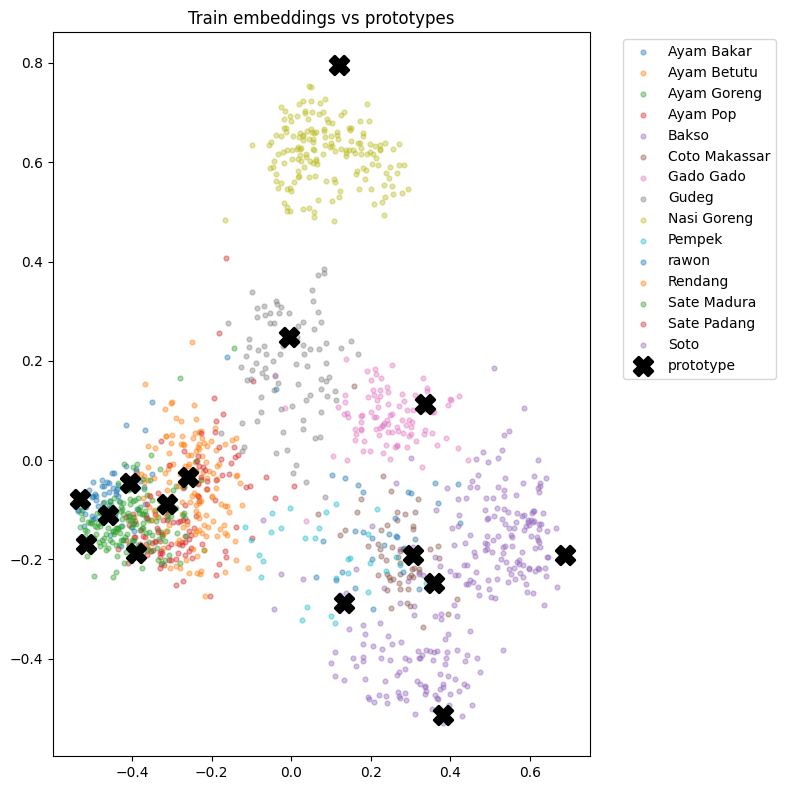

In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict

def visualize_with_prototypes(
    X, y, prototypes,
    id2label=None,
    title="Embedding + Prototypes",
    max_points_per_class=200,
    figsize=(8, 8)
):
    """
    X : Tensor [N, D]
    y : Tensor [N]
    prototypes : dict {class_id: Tensor[D]}
    """

    device = X.device
    X = F.normalize(X, dim=1)

    # ----- stack prototypes -----
    proto_ids = sorted(prototypes.keys())
    proto_mat = torch.stack([prototypes[c] for c in proto_ids]).to(device)
    proto_mat = F.normalize(proto_mat, dim=1)

    # ----- compute self accuracy -----
    with torch.no_grad():
        sims = X @ proto_mat.T
        preds = sims.argmax(dim=1)
        correct = sum(proto_ids[p] == y[i].item() for i, p in enumerate(preds))
        acc = correct / len(y)

        top1 = sims.max(dim=1).values
        mean_sim = top1.mean().item()
        min_sim  = top1.min().item()

    print(f"[Prototype eval]")
    print(f"  acc      : {acc:.3f}")
    print(f"  mean sim : {mean_sim:.3f}")
    print(f"  min sim  : {min_sim:.3f}")

    # ----- subsample for plotting -----
    idxs = []
    per_class = defaultdict(list)

    for i, cls in enumerate(y.tolist()):
        if len(per_class[cls]) < max_points_per_class:
            per_class[cls].append(i)
            idxs.append(i)

    X_plot = X[idxs].cpu().numpy()
    y_plot = y[idxs].cpu().numpy()

    proto_plot = proto_mat.cpu().numpy()

    # ----- PCA -----
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(
        torch.cat([torch.tensor(X_plot), torch.tensor(proto_plot)]).numpy()
    )

    X_pts   = X_2d[:len(X_plot)]
    P_pts   = X_2d[len(X_plot):]

    # ----- plot -----
    plt.figure(figsize=figsize)

    for cls in proto_ids:
        mask = (y_plot == cls)
        label = id2label[cls] if id2label else f"class {cls}"
        plt.scatter(
            X_pts[mask, 0],
            X_pts[mask, 1],
            s=12,
            alpha=0.4,
            label=label
        )

    plt.scatter(
        P_pts[:, 0],
        P_pts[:, 1],
        c="black",
        s=180,
        marker="X",
        linewidths=2,
        label="prototype"
    )

    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    return {
        "acc": acc,
        "mean_sim": mean_sim,
        "min_sim": min_sim
    }

stats_train = visualize_with_prototypes(
    X_train_1,
    y_train_1,
    prototypes_v2,
    id2label=id2label,
    title="Train embeddings vs prototypes"
)

[Prototype eval]
  acc      : 0.873
  mean sim : 0.697
  min sim  : 0.372


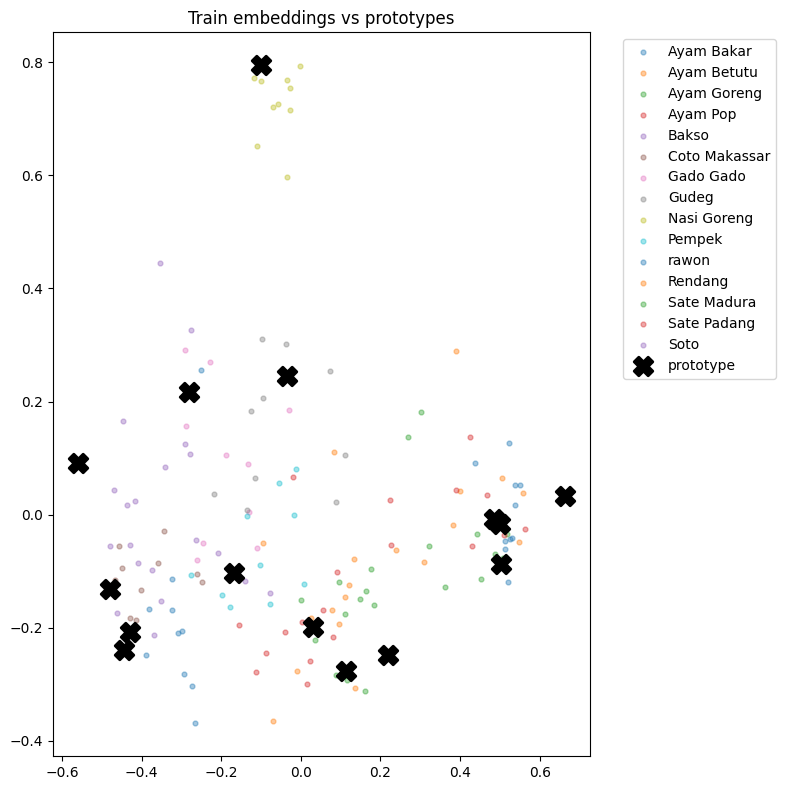

In [42]:
stats_train = visualize_with_prototypes(
    X_val,
    y_val,
    prototypes_v2,
    id2label=id2label,
    title="Train embeddings vs prototypes"
)

In [43]:
correct = 0
with torch.no_grad():
    proto_mat = torch.stack(list(prototypes_v2.values()))
    proto_ids = list(prototypes_v2.keys())

    sims = X_val @ proto_mat.T
    preds = sims.argmax(dim=1)

    for i, p in enumerate(preds):
        if proto_ids[p] == y_val[i].item():
            correct += 1

print("Prototype holdout acc (GT val):", correct / len(y_val))

Prototype holdout acc (GT val): 0.8733333333333333


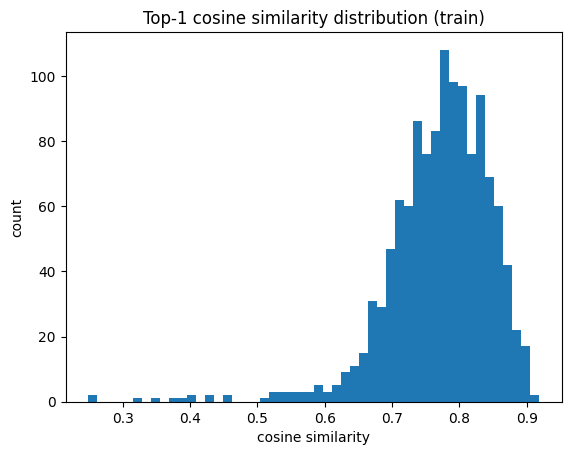

In [44]:
import matplotlib.pyplot as plt

plt.hist(
    (X_train_1 @ torch.stack(list(prototypes_v2.values())).T)
    .max(dim=1).values.cpu().numpy(),
    bins=50
)
plt.title("Top-1 cosine similarity distribution (train)")
plt.xlabel("cosine similarity")
plt.ylabel("count")
plt.show()

# **Training Final Model**

# **Predict**

In [45]:
print("Predicting with embedding + head...")
head.eval()
preds = []
paths = []

with torch.no_grad():
    for imgs, filepath in tqdm(test_loader):
        imgs = imgs.to(device)

        emb = extract_embedding(imgs)
        emb = emb.to(device)

        logits = head(emb)
        pred = torch.argmax(logits, dim=1)

        preds.append(pred.cpu())
        paths.extend(filepath)

preds = torch.cat(preds, dim=0)

print("Prediction ready!")
print("Total preds:", len(preds))

Predicting with embedding + head...


100%|██████████| 65/65 [00:40<00:00,  1.60it/s]

Prediction ready!
Total preds: 2057


In [46]:
print("Predicting with prototype (cosine)...")

proto_mat = torch.stack(list(prototypes.values())).to(device)  # (C, 768)
proto_ids = torch.tensor(list(prototypes.keys())).to(device)

proto_mat = F.normalize(proto_mat, dim=1)

preds = []
paths = []

with torch.no_grad():
    for imgs, filepath in tqdm(test_loader):
        imgs = imgs.to(device)

        emb = extract_embedding(imgs)         # (B, 768)
        emb = F.normalize(emb, dim=1)

        sims = emb @ proto_mat.T              # (B, C)
        idx  = sims.argmax(dim=1)
        pred = proto_ids[idx]

        preds.append(pred.cpu())
        paths.extend(filepath)

preds = torch.cat(preds)
print("Prototype prediction ready!")

Predicting with prototype (cosine)...


100%|██████████| 65/65 [00:41<00:00,  1.58it/s]

Prototype prediction ready!


In [47]:
print("Assigning prediction to dataframe...")

test_df["label"] = preds
test_df["label_str"] = test_df["label"].map(id2label)
test_df["filename"] = test_df["filepath"].apply(lambda p: p.stem).astype(int)

print("\nFinish!")
print(test_df.head())

Assigning prediction to dataframe...

Finish!
                                            filepath  label    label_str  \
0  /kaggle/input/data-mining-action-2025/test/tes...      8  Nasi Goreng   
1  /kaggle/input/data-mining-action-2025/test/tes...      1  Ayam Betutu   
2  /kaggle/input/data-mining-action-2025/test/tes...      1  Ayam Betutu   
3  /kaggle/input/data-mining-action-2025/test/tes...      7        Gudeg   
4  /kaggle/input/data-mining-action-2025/test/tes...      8  Nasi Goreng   

   filename  
0      1269  
1       733  
2      2008  
3       106  
4       375  


In [48]:
test_sub = test_df.sort_values("filename")

submission = test_sub[["filename", "label_str"]]
submission.rename(columns={"filename": "ID",
                           "label_str": "label"}, inplace=True)

filename = "submission.csv"
submission.to_csv(filename, index=False)
print(f"Submission saved to {filename}!")
print(submission.head())
print(submission["label"].value_counts())

Submission saved to submission.csv!
      ID        label
1774   1  Sate Padang
481    2    Gado Gado
510    3   Ayam Bakar
1323   4      Rendang
255    5        Gudeg
label
Nasi Goreng      234
Sate Madura      213
Soto             194
Ayam Bakar       190
Ayam Goreng      171
Bakso            138
Coto Makassar    133
Sate Padang      131
Pempek           122
Gado Gado        118
Gudeg             93
rawon             89
Ayam Betutu       83
Ayam Pop          76
Rendang           72
Name: count, dtype: int64
